> **DO NOT EDIT IF INSIDE tsds folder**


# Week 4: Artificial Neural Networks 3

*Wednesday, February 26, 2019*

We learned about feedforward neural networks over the last two weeks, along with most of the fundamental maths, algorithms, tricks, etc. that go into training them. Knowing how signal propagates forward, how gradients flow backwards and how weights get updates, we are now ready to release our imagination and create some deep neural networks that can do remarkable things. We will focus on two of the most **powerful architectures**, the Convolutional Neural Network (CNN) and the Recurrent Neural Network (RNN), which have revolutionalized image recognition and sequence modeling across all fields over the last 10 years.

- Part 4.1: Convolutional Neural Networks
- Part 4.2: Recurrent Neural Networks

**Questions**: Outside of class, use [issue](https://github.com/abjer/tsds/issues) on GitHub for asking questions.

In [226]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import mnist_loader
from scipy.interpolate import interp1d
from datetime import datetime as dt
import requests as rq
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable

## Exercises

### Part 4.1: Convolutional Neural Networks

The problem with feed forward images when classifying images is that the input layer looks at the whole image at the same time. Each input neuron thus becomes associated with a specific pixel, and as the network learns it may grow to expect a certain signal to emerge at that specific pixel. But if you imagine an image of a cat, features, like the whiskers, which make it cat-like are not bound to a specific *place* in the image – they can be in the centre, top corner, or any other place.

CNNs solve this problem, with what's called *convolutional layers*. A convolutional input layer, for example, doesn't have a single weight for each input value. Instead, it has one or more much smaller *filters*, each one a set of input neurons (often $3 \times 3 \times d$ where $d$ is the depth of the input image) that gets *convolved* across the input image to produce a new image, called an *activation map*. [Here](https://github.com/vdumoulin/conv_arithmetic) are some nice gifs that illustrate different ways one can convolve a weight matrix across an input image.

#### Pen and paper

To get your intuition for computations on input data in CNNs fine-tuned, I have a few small quizzes for you. First, we'll consider the size of the parameter space.

> **Ex. 4.1.1**: Imagine you have a CNN with just one convolutional layer with a single filter. All it does, is take an input image and produce an activation map. The dimensionality of the filter in your convolutional layer is $5 \times 5 \times 3$. How many weights (or *parameters*) are there in this model?
>
> *Hint*: Don't forget the bias!

In [2]:
5 * 5 * 3 + 1

76

Here's a useful formula for computing the size of the activation map resulting from a convolution. 
If you have filter that is $F$ wide, your input image is $W_0$ wide, you are padding the sizes by
$P$ and your stride is $S$, the resulting image will have width:

$$ W_1 = \frac{W_0 - F + 2P}{S} + 1 $$

> **Ex. 4.1.2**: You input an image of dimensions $28 \times 28 \times 3$, use a padding of 2, a stride of 1,
and then slide your $5 \times 5 \times 3$ filter across the image. What is the dimensionality of the resulting activation map?

In [10]:
(28 - 5 + 2*1) / 1 + 1

26.0

> **Ex. 4.1.3**: Let's say you now want to use a stride of 2, instead of 1. What problem does immediately cause?
How can we solve it?

Choosing stride 2, we see that the number of convolutions is not an integer. 

In [6]:
(28 - 5 + 2*1) / 2 + 1

13.5

The number of convolution has to be an integer, otherwise we have to have asymmetric padding, which is not very
nice. To make it an integer, we can change the dimensinality of the filter, to an even number.

In [14]:
(28 - 6 + 2*1) / 2 + 1

13.0

*Maxpooling* is a method used a lot in CNNs, which downsamples the size of an activation map. It's used primarily to reduce amount of parameters and computations in the network, and to avoid overfitting. Here's an illustration of how it works:

![img](http://cs231n.github.io/assets/cnn/maxpool.jpeg)

Typically, for each $2 \times 2$ square in your activation map, you pick the largest value in that square. You do this independently for every depth slice in your activation map.

**Note:** In PyTorch, the dimension of data is a little different from what you may expect. The first index,
indexes datapoints, the second *channels*, and the last two are the dimensions of the input data. So if
you have a batch of data containing 100 datapoints, each one an RGB image (so 3 channels: red, green, blue)
with resolution $128 \times 128$, then the dimensionality of your input data is (100, 3, 128, 128).

> **Ex. 4.1.4**: Given the activation map below, what is the corresponding activation map after maxpooling ($2 \times 2$ filter, stride 2)? Report the shape of the resulting activation map.
>
> *Hint*: Don't try to do this manually, it will be a nightmare. Instead, look for functionality in PyTorch's API that will help you along.

In [44]:
torch.manual_seed(0)
activation_map = torch.randn(10, 1, 28, 28)

In [46]:
# Solution
m = torch.nn.MaxPool2d((2, 2), stride=2)
m(activation_map).shape

torch.Size([10, 1, 14, 14])

#### CNNs in PyTorch

There are many ways you can define your neural network models using PyTorch. Last week I gave an example of how
to do it using `Sequential`, which is probably the easiest way to do it. But you can also write the network as
a Python class which gives you a bit more freedom. Below I've given an example that implements the same network
in two different ways. The code below assumes input images of shape $28 \times 28 \times 1$.

In [7]:
# Example 1:
# ----------

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

model = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    Flatten(),
    nn.Linear(10 * 14 * 14, 10)
)

# Example 2:
# ----------

class Network(nn.Module):
    
    def __init__(self):
        super(Network, self).__init__()
        self.conv = nn.Conv2d(1, 10, 3, 1, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(10 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 10 * 14 * 14)
        x = self.fc(x)
        return x

net = Network()

The first way is easier to read, but the second way offers a bit more design flexibility. For example, when using
`Sequential`, in order to flatten the array of neurons resulting from the convolution, so we could apply a linear
layer, we had to define a `Flatten` class. With the second way we can just reshape it with `view`.

In the following exercises you choose yourself how to write your networks, whether with `Sequential` or as a class.

We will use the MNIST dataset one last time now.

In [222]:
training_data, validation_data, test_data = mnist_loader.load_data()

# Training data
x = torch.from_numpy(training_data[0])
y_ = torch.from_numpy(training_data[1])
y = torch.zeros(x.shape[0], 10)
y[torch.arange(x.shape[0]), y_] = 1

# Test data
x_test = torch.from_numpy(test_data[0])
y_test_ = torch.from_numpy(test_data[1])
y_test = torch.zeros(x_test.shape[0], 10)
y_test[torch.arange(x_test.shape[0]), y_test_] = 1

# Reshape to comply with PyTorch standard input format
x = x.view(-1, 1, 28, 28)
x_test = x_test.view(-1, 1, 28, 28)

> **Ex. 4.1.5**: Implement Nielsen's [last convolutional neural network](http://neuralnetworksanddeeplearning.com/chap6.html#convolutional_neural_networks_in_practice)
(the one with two convolutional layers and dropout), and score an accuracy higher than 98%. It doesn't have to be
fully identical, but his solution is pretty great, so getting close is a cheap way to score a high accuracy.
>
> *Hint:* The cost function `torch.nn.MSELoss(reduction='mean')` works great with `learning_rate=1e-3` or less.

In [200]:
def accuracy(y_pred, y):
    _, y_pred = torch.max(y_pred.data, 1)
    _, y = torch.max(y.data, 1)
    return np.mean((y_pred == y).numpy())

model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 20, 5, 1, 0),   # First conv. layer
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(20, 40, 5, 1, 0),  # Second conv. layer
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    Flatten(),
    torch.nn.Linear(4 * 4 * 40, 1000), # First linear layer
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 1000),       # Second linear layer
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 10),         # Last linear layer
    torch.nn.Softmax()
)

# Parameters
learning_rate = 1e-4
epochs = 10
mini_batch_size = 100

# Cost function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    
    permutation = torch.randperm(x.size()[0])
    for k in np.arange(0, x.size()[0], mini_batch_size):
        
        # Extract mini-batch data
        mini_batch_indices = permutation[k:k+mini_batch_size]
        x_ = x[mini_batch_indices]
        y_ = y[mini_batch_indices]
        
        # SGD step
        y_pred = model(x_)
        loss = loss_fn(y_pred, y_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    y_test_pred = model(x_test)
    loss_test = loss_fn(y_test_pred, y_test)
    acc_test = accuracy(y_test_pred, y_test)
    print(t, "train:", loss.item(), "| test:", loss_test.item(), "| test acc:", acc_test)

0 train: 0.011937170289456844 | test: 0.00998382642865181 | test acc: 0.9351
1 train: 0.0035227506887167692 | test: 0.005334936082363129 | test acc: 0.9676
2 train: 0.005330743733793497 | test: 0.004357931669801474 | test acc: 0.9728
3 train: 0.0015470098005607724 | test: 0.0032513749320060015 | test acc: 0.9794
4 train: 0.0023332417476922274 | test: 0.0029118885286152363 | test acc: 0.9814
5 train: 0.006429140456020832 | test: 0.0026084717828780413 | test acc: 0.9832
6 train: 0.0016077831387519836 | test: 0.0023955758661031723 | test acc: 0.9842
7 train: 0.0024772111792117357 | test: 0.0021383564453572035 | test acc: 0.9863
8 train: 0.0007043622899800539 | test: 0.002078099176287651 | test acc: 0.9866
9 train: 0.0010532139567658305 | test: 0.001923154341056943 | test acc: 0.9869


The MNIST dataset is a great benchmark because it allows us to directly measure the performance of a neural
network against the human eye. But often, the association between datapoint and label is not as clear, yet we
still want to do prediction.

I went on [Kaggle.com](www.kaggle.com) and looked for some *harder* datasets. At the time of writing there's
[a competetion](https://www.kaggle.com/c/petfinder-adoption-prediction) where you can win up to $\$$10.000 by
predicting how quickly pets get adopted (on a pet-adoption site) based on meta data and images of the pets. From that competetion, I prepared a dataset of $128 \times 128$ images along with adoption time (lower is better, see description on Kaggle). In the actual competetion people are using more data sources than just image, but for
now, let's see how well we can do with just that.

> **Ex. 4.1.6**: Load the prepared dataset and build a CNN that predicts adoption-time category from the image.
Leave out the last 1000 datapoints from training and save them for validation. You have complete freedom in how
you want to construct the neural network (choise of cost function, inner architecture, training hyperparameters,
etc.). Report an accuracy on the test set (last 1000 points) that's higher than the baseline (0.273). Using your
adoptability predictor, visualize the 5 most adoptable dogs.
>
> As an extra bonus, I also included a test dataset with no corresponding target array. You can take your model and try to predict the test data, and format it similar to the `sample_submission.csv` file and submit your predictions to the competetion to get an estimate of the true performance of your model. Let me know what you score if you do that. And if you choose to join the competetion and try to win the money, I'd also like to hear about your progress.
>
> Also, note that to get high accuracy, you need to make a network that is bigger than what you had in the previous exercise. This will take a long time to train (hours at least). If you have a computer with a small
CPU you will have to make do with a smaller neural network, and thus a lower accuracy. But you should still be able to score above the baseline.

In [2]:
# Load data
x = torch.from_numpy(np.load('x.npy').astype(np.float32))
y_ = torch.from_numpy(np.load('y.npy').astype(int))
y = torch.zeros(x.shape[0], 5)
y[torch.arange(x.shape[0]), y_] = 1

# Split into train and test
x_test = x[-1000:]
y_test = y[-1000:]
x = x[:-1000]
y = y[:-1000]

In [3]:
# Baseline
print(max(y.sum(0))/y.sum())

tensor(0.2729)


In [12]:
def accuracy(y_pred, y):
    _, y_pred = torch.max(y_pred.data, 1)
    _, y = torch.max(y.data, 1)
    return np.mean((y_pred == y).numpy())

model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 20, 5, 1, 2),   # First conv. layer
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(20, 40, 5, 1, 2),  # Second conv. layer
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    Flatten(),
    torch.nn.Linear(32 * 32 * 40, 1000), # First linear layer
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 1000),       # Second linear layer
    torch.nn.Dropout(0.5),
    torch.nn.Linear(1000, 5),         # Last linear layer
    torch.nn.Softmax()
)

# Parameters
learning_rate = 1e-5
epochs = 10
mini_batch_size = 100

# Cost function
loss_fn = torch.nn.MSELoss(reduction='mean')

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for t in range(epochs):
    
    print("Epoch %d:" % t, end=" ")
    
    permutation = torch.randperm(x.size()[0])
    for k in log_progress(np.arange(0, x.size()[0], mini_batch_size), every=1):

        # Extract mini-batch
        mini_batch_indices = permutation[k:k+mini_batch_size]
        x_ = x[mini_batch_indices]
        y_ = y[mini_batch_indices]
        
        # SGD step
        y_pred = model(x_)
        loss = loss_fn(y_pred, y_)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    y_test_pred = model(x_test)
    loss_test = loss_fn(y_test_pred, y_test)
    acc_test = accuracy(y_test_pred, y_test)
    print("   ", "train:", loss.item(), "| test:", loss_test.item(), "| test acc:", acc_test, "\n")

Epoch 0: 

    train: 0.2923070192337036 | test: 0.2903693616390228 | test acc: 0.274 

Epoch 1: 

    train: 0.2763795852661133 | test: 0.28994685411453247 | test acc: 0.275 

Epoch 2: 

    train: 0.2921760082244873 | test: 0.2893425524234772 | test acc: 0.273 

Epoch 3: 

KeyboardInterrupt: 

### Part 4.2: Recurrent Neural Networks



At this point, you may have noticed the obvious limitation to vanilla neural networks and CNNs, which is that they
are extremely contrained in their processing of data. Input and output must be of a specific size and computation
happens over a fixed number of layers. Recurrent Neural Networks (RNNs) offer an exciting alternative to this
constrained computing paradigm, as they model data in **sequence**. There is no inherent constraint to how long
or short sequences can be, and likewise for outputs.

Training RNNs looks slightly different than feed forward networks, because we have to reuse outputs of each
iteration as inputs to the next iteration. Therefore I have given an example below where I fit an RNN to
Shakespeare's Hamlet.

In [129]:
# Download the data (thanks MIT)
response = rq.get("http://shakespeare.mit.edu/hamlet/full.html")
hamlet = BeautifulSoup(response.content, "html.parser").getText()

# Convert text to character-level one-hot encoding
hamlet_one_hot = pd.get_dummies(pd.Series(list(hamlet)))
character_vec = hamlet_one_hot.columns
x = torch.from_numpy(hamlet_one_hot.values.astype(np.float32))

In [325]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        
        # Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Neural network layers. Rather than giving the input as a one-hot
        # vector, we represent it as a point in a high-dimensional space (i.e.
        # "an embedding"). This tends to work better.
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden):
        signal = self.encoder(input_).view(1, 1, -1)  # Embed input character
        output, hidden = self.rnn(signal, hidden)     # Get output and hidden vector(s)
        prediction = self.decoder(output.view(1, -1))     # Decode to "prediction" vector
        
        return prediction, hidden

    def init_hidden(self):
        return (
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        )
    
epochs = 5000
seq_len = 200
learning_rate = 1e-2
n_layers = 2

model = RNN(len(character_vec), 100, len(character_vec), n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# We're collecting the losses so we can plot how they (hopefully) decrease over time
all_losses = []
fraction_correct = []
for t in tqdm(range(epochs)):
    
    # Initiate a hidden vector for 
    hidden = model.init_hidden()
    
    # Pick a random input and output sequence. Here we are only taking one sequence
    # per epoch, but normally people take a batch of sequences. Check https://github
    # .com/spro/char-rnn.pytorch for an example on how to do that
    i = np.random.randint(0, x.size(0)-seq_len)
    input_ = torch.max(x[i:i+seq_len], 1)[1]      # torch.max(...)[1] gets the character in terms of its index, so
    target = torch.max(x[i+1:i+1+seq_len], 1)[1]  # input_ will be something like torch.tensor([2, 1, 4, 0, ... 1])
    
    # Backprop through time. Here we are just summing the losses from each timestep
    # and do backpropagation on the variable that holds the sum. PyTorch allows for that
    optimizer.zero_grad()
    loss = 0
    correct = 0
    for j in range(input_.size(0)):
        output, hidden = model(input_[j], hidden)
        loss += loss_fn(output.view(1, -1), target[j].view(1, ))
        correct += int(torch.max(output.view(1, -1), 1)[1][0] == target[j])
    
    # SGD step
    loss.backward()
    optimizer.step()
    
    # Collect loss value for plot
    all_losses.append(float(loss))
    fraction_correct.append(correct / input_.size(0))
        
    # Progress
    if t % 10 == 0:
        print(t, "| loss:", float(loss), "| fraction correct:", fraction_correct[-1])
    

0 | loss: 837.5260009765625 | fraction correct: 0.02
10 | loss: 758.2477416992188 | fraction correct: 0.12
20 | loss: 688.7192993164062 | fraction correct: 0.15
30 | loss: 577.0355834960938 | fraction correct: 0.245
40 | loss: 546.7378540039062 | fraction correct: 0.21
50 | loss: 501.7413635253906 | fraction correct: 0.33
60 | loss: 483.5766296386719 | fraction correct: 0.295
70 | loss: 494.6862487792969 | fraction correct: 0.325
80 | loss: 497.8192138671875 | fraction correct: 0.28
90 | loss: 472.5584716796875 | fraction correct: 0.355
100 | loss: 495.93133544921875 | fraction correct: 0.31
110 | loss: 442.7196044921875 | fraction correct: 0.345
120 | loss: 405.5710754394531 | fraction correct: 0.49
130 | loss: 469.5902404785156 | fraction correct: 0.34
140 | loss: 452.2145080566406 | fraction correct: 0.325
150 | loss: 401.5863342285156 | fraction correct: 0.485
160 | loss: 442.0084228515625 | fraction correct: 0.38
170 | loss: 487.2173156738281 | fraction correct: 0.3
180 | loss: 46

1470 | loss: 391.3751525878906 | fraction correct: 0.41
1480 | loss: 391.15386962890625 | fraction correct: 0.435
1490 | loss: 338.9270324707031 | fraction correct: 0.51
1500 | loss: 300.7746276855469 | fraction correct: 0.545
1510 | loss: 416.2909851074219 | fraction correct: 0.4
1520 | loss: 358.7539978027344 | fraction correct: 0.42
1530 | loss: 306.18524169921875 | fraction correct: 0.55
1540 | loss: 394.9738464355469 | fraction correct: 0.4
1550 | loss: 406.2026062011719 | fraction correct: 0.42
1560 | loss: 349.67510986328125 | fraction correct: 0.465
1570 | loss: 367.8939208984375 | fraction correct: 0.47
1580 | loss: 352.996826171875 | fraction correct: 0.48
1590 | loss: 348.6156005859375 | fraction correct: 0.465
1600 | loss: 329.8912048339844 | fraction correct: 0.485
1610 | loss: 373.4576110839844 | fraction correct: 0.43
1620 | loss: 306.124267578125 | fraction correct: 0.59
1630 | loss: 257.8166809082031 | fraction correct: 0.645
1640 | loss: 373.0889892578125 | fraction c

2930 | loss: 266.2772521972656 | fraction correct: 0.62
2940 | loss: 318.976318359375 | fraction correct: 0.545
2950 | loss: 293.948486328125 | fraction correct: 0.585
2960 | loss: 311.27606201171875 | fraction correct: 0.535
2970 | loss: 261.1993713378906 | fraction correct: 0.61
2980 | loss: 299.5662841796875 | fraction correct: 0.505
2990 | loss: 298.9473876953125 | fraction correct: 0.575
3000 | loss: 351.17596435546875 | fraction correct: 0.465
3010 | loss: 327.7618713378906 | fraction correct: 0.55
3020 | loss: 379.4090881347656 | fraction correct: 0.44
3030 | loss: 319.7386779785156 | fraction correct: 0.46
3040 | loss: 399.6684875488281 | fraction correct: 0.43
3050 | loss: 345.6409606933594 | fraction correct: 0.465
3060 | loss: 322.0110778808594 | fraction correct: 0.55
3070 | loss: 298.11517333984375 | fraction correct: 0.55
3080 | loss: 302.67315673828125 | fraction correct: 0.55
3090 | loss: 249.62315368652344 | fraction correct: 0.58
3100 | loss: 255.69692993164062 | frac

4390 | loss: 289.9786376953125 | fraction correct: 0.555
4400 | loss: 251.96641540527344 | fraction correct: 0.625
4410 | loss: 353.3132019042969 | fraction correct: 0.45
4420 | loss: 313.5442199707031 | fraction correct: 0.53
4430 | loss: 268.6750793457031 | fraction correct: 0.595
4440 | loss: 339.4184265136719 | fraction correct: 0.53
4450 | loss: 236.89967346191406 | fraction correct: 0.605
4460 | loss: 299.78985595703125 | fraction correct: 0.55
4470 | loss: 325.7078857421875 | fraction correct: 0.515
4480 | loss: 327.0940246582031 | fraction correct: 0.49
4490 | loss: 338.7983703613281 | fraction correct: 0.5
4500 | loss: 274.0870056152344 | fraction correct: 0.535
4510 | loss: 270.2533874511719 | fraction correct: 0.595
4520 | loss: 322.9829406738281 | fraction correct: 0.505
4530 | loss: 254.1712646484375 | fraction correct: 0.63
4540 | loss: 217.89959716796875 | fraction correct: 0.665
4550 | loss: 274.8757629394531 | fraction correct: 0.62
4560 | loss: 304.3502502441406 | fra

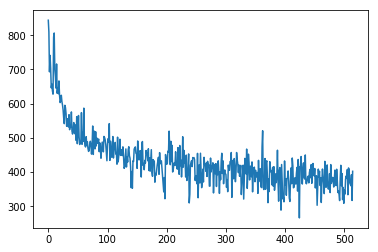

In [277]:
plt.plot(all_losses)

Looks the network learns! But we could have probably run it for a bit longer and gotten a better result. I'll
leave that to you. But let's see what it can do.

> **Ex. 4.2.1**: Train the network the a while (the longer the better) until its error has settled in some local
minimum. Then go ahead and generate some gibberish Hamlet with it!

In [303]:
hidden = model.init_hidden()
for j in range(input_.size(0)):
    output, hidden = model(input_[j], hidden)

In [307]:
gibberish_hamlet = ""
for _ in range(1000):
    output, hidden = model(input_[2], hidden)
    gibberish_hamlet += character_vec[torch.max(output, 1)[1][0]]
    print(gibberish_hamlet)

h
ho
hoh
hohh
hohho
hohhoo
hohhooo
hohhoooE
hohhoooEE
hohhoooEEE
hohhoooEEEE
hohhoooEEEEE
hohhoooEEEEEE
hohhoooEEEEEEE
hohhoooEEEEEEEE
hohhoooEEEEEEEEE
hohhoooEEEEEEEEEE
hohhoooEEEEEEEEEEE
hohhoooEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEE

hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
hohhoooEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

In [270]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        
        # Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Neural network layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden):
        seq_len = input_.size(0)
        signal = self.encoder(input_).view(1, seq_len, -1)
        signal, hidden = self.rnn(signal, hidden)
        signal = self.decoder(signal.view(1, -1))
        
        return signal, hidden

    def init_hidden(self):
        return (
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        )
    
epochs = 5000
seq_len = 200
learning_rate = 1e-3
n_layers = 2

model = RNN(len(character_vec), 100, len(character_vec), n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

all_losses = []
for t in tqdm(range(epochs)):
    
    # Initiate a hidden vector
    hidden = model.init_hidden()
    
    # Pick a random input and output sequence
    i = np.random.randint(0, x.size(0)-seq_len)
    input_ = torch.max(x[i:i+seq_len], 1)[1]
    target = torch.max(x[i+1:i+1+seq_len], 1)[1]
    
    # Backprop through time
    optimizer.zero_grad()
    output, hidden = model(input_, hidden)
    loss = loss_fn(output.view(1, -1), target[j].view(1, ))
    loss.backward()
    optimizer.step()
    
    # Log
    all_losses.append(float(loss))
        
    # Progress
    if t % 10 == 0:
        print(t, loss)
    

RuntimeError: size mismatch, m1: [1 x 20000], m2: [100 x 66] at /Users/soumith/b101_2/2019_02_08/wheel_build_dirs/wheel_3.7/pytorch/aten/src/TH/generic/THTensorMath.cpp:940